## Getting started
Load basic libraries 

In [219]:
import dimcli
from dimcli.shortcuts import dslquery, dslqueryall
import pandas as pd
from pandas.io.json import json_normalize
import plotly_express as px
import time

In [62]:
GRIDID = "grid.6906.9" # Erasmus University Rotterdam

### 1 Extract publications about 'design' 

```
* design philosophy (any design-related thing)
* CWTS => biblio research institute at Leiden [Ludo]
* evolution over time of design stuff (which areas)
* what Rotterdam is doing (eg pubs per year)
   * compared to Netherlands
   * compared to Europe
   * compared to rest of world

```

In [177]:
data = dslqueryall(f"""search publications in title_abstract_only for "design" where research_orgs.id="{GRIDID}" return publications[basics+FOR]""")
print(data.stats)
df = json_normalize(data.publications)

1000 / 1870
1870 / 1870
{'total_count': 1870}


In [178]:
df.head()

,FOR,author_affiliations,id,issue,journal.id,journal.title,pages,title,type,volume,year
0,"[{'id': '3468', 'name': '1701 Psychology'}]","[[{'first_name': 'Kim', 'last_name': 'Melchior...",pub.1114921671,1,jour.1297400,Trials,277,Metacognitive therapy versus exposure and resp...,article,20,2019
1,"[{'id': '3177', 'name': '1117 Public Health an...","[[{'first_name': 'Siri', 'last_name': 'Wiig', ...",pub.1114053482,1,jour.1039457,BMC Research Notes,259,How to deal with context? A context-mapping to...,article,12,2019
2,"[{'id': '2358', 'name': '0104 Statistics'}]","[[{'first_name': 'Stefano', 'last_name': 'Tass...",pub.1116083197,NaN,jour.1313652,Social Networks,10-22,Does it take three to dance the Tango? Organiz...,article,59,2019
3,"[{'id': '3292', 'name': '1402 Applied Economic...","[[{'first_name': 'Charmaine G.', 'last_name': ...",pub.1104046321,4,jour.1327853,New Political Economy,1-19,Beyond Patrimonial Plunder: The Use and Abuse ...,article,24,2019
4,"[{'id': '2790', 'name': '0806 Information Syst...","[[{'first_name': 'Habibollah', 'last_name': 'P...",pub.1113404032,J Am Soc Nephrol 18 October (10) 2007,jour.1013854,International Journal of Medical Informatics,18-26,Preventing potential drug-drug interactions th...,article,127,2019


In [179]:
dfyear = df.groupby("year", as_index=False)['id'].count()
dfyear.rename(columns={'id': 'count'}, inplace=True)

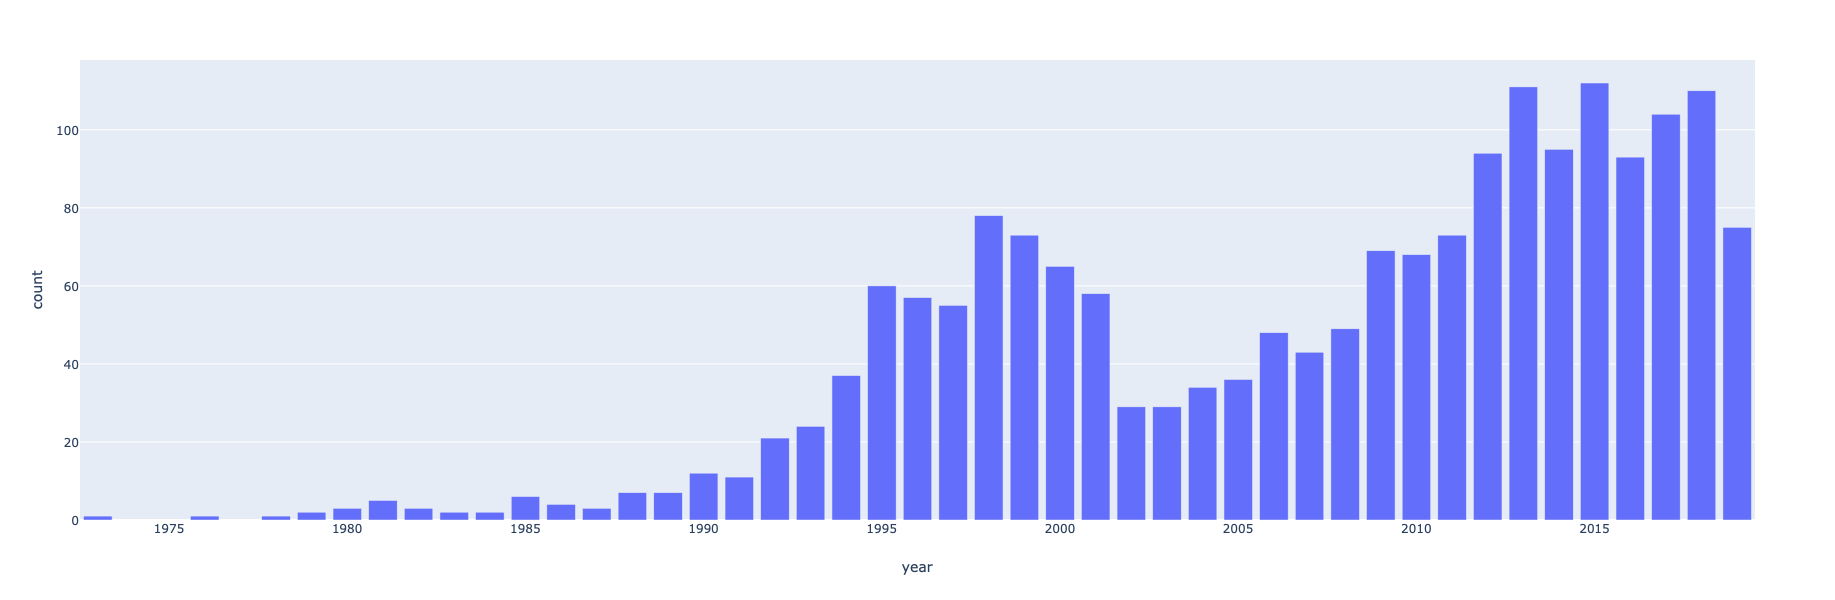

In [180]:
px.bar(dfyear, x="year", y="count")

### 2. Distributions of pubs per journals and years

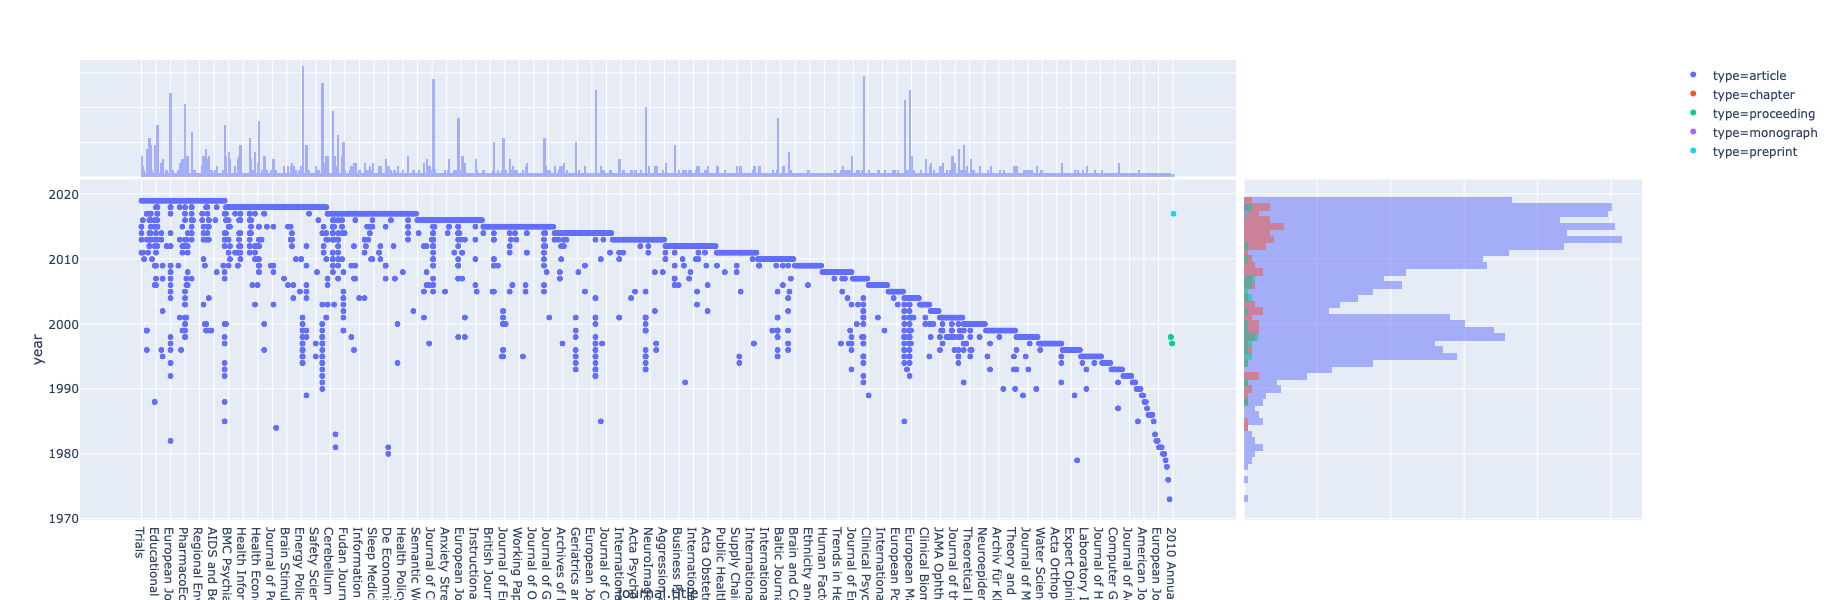

In [69]:
px.scatter(df, x="journal.title", y="year", color="type", marginal_x="histogram", marginal_y="histogram")

### 3. Distributions of pubs per broad subject areas (FOR) and years

In [181]:
# ensure that all pubs have a valid (empty, even) FOR value 
for x in data.publications:
    if not 'FOR' in x:
        x['FOR'] = []   

In [191]:
df2 = json_normalize(data.publications, record_path=['FOR'], meta=["id", "type", ["journal", "title"], "year"], errors='ignore', record_prefix='for_')

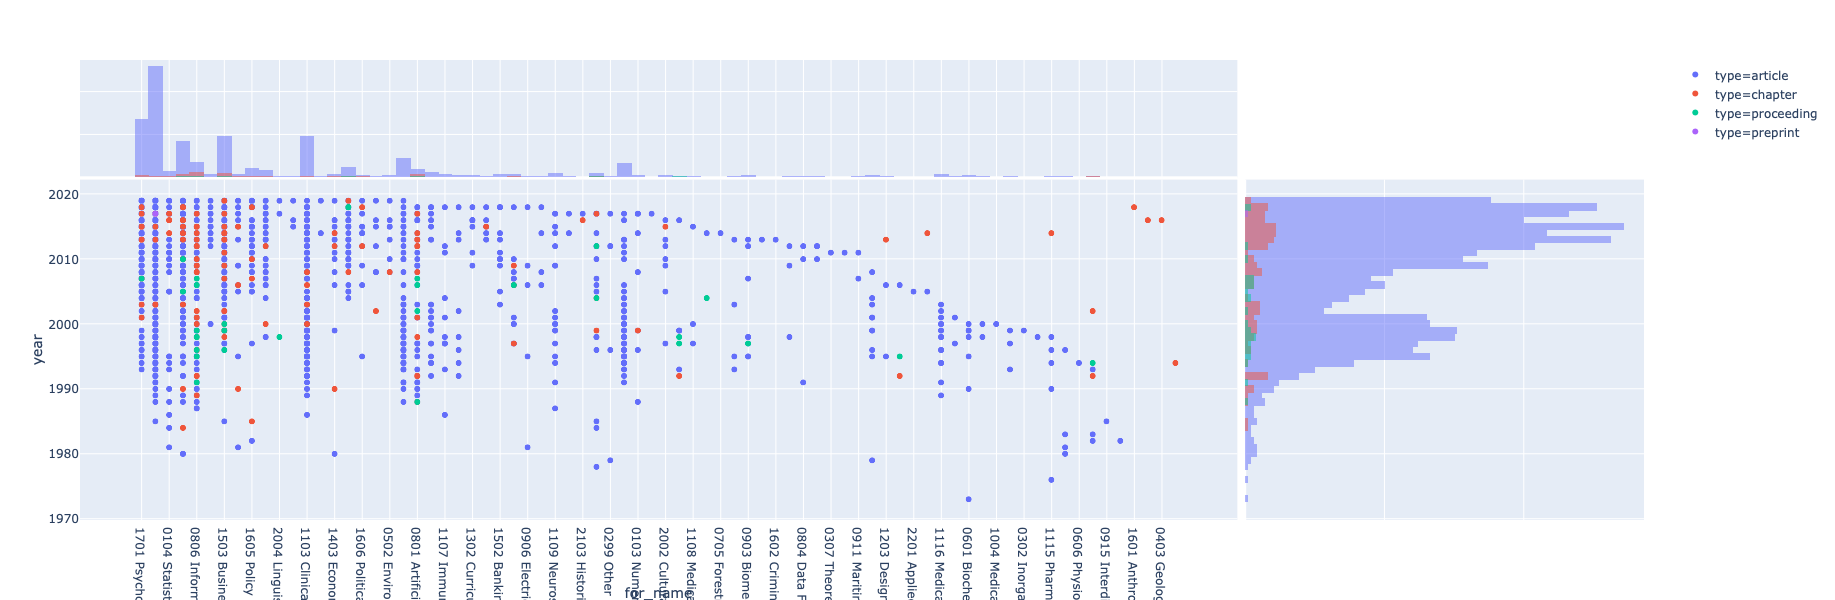

In [192]:
px.scatter(df2, x="for_name", y="year", color="type", marginal_x="histogram", marginal_y="histogram")

###  4. Rotterdam university publications in this area compared to other top instituions in the Netherlands BY YEAR

First let's pull out a list of the top 30 dutch institutions active in the 'design' area

In [224]:
df = dslquery(f"""search publications in title_abstract_only for "design" where research_org_countries.id="NL" return research_orgs limit 1000""").as_dataframe()

In [225]:
grid_ids = df.query("country_name=='Netherlands'")[:30][['id','name']]

In [223]:
grid_ids

,id,name
0,grid.5292.c,Delft University of Technology
1,grid.6852.9,Eindhoven University of Technology
2,grid.6214.1,University of Twente
3,grid.5645.2,Erasmus University Medical Center
4,grid.5012.6,Maastricht University
5,grid.7692.a,University Medical Center Utrecht
6,grid.5477.1,Utrecht University
7,grid.10417.33,Radboud University Nijmegen Medical Centre
8,grid.10419.3d,Leiden University Medical Center
9,grid.12380.38,VU University Amsterdam


Now we loop over all of these institutions and pull out detailed publication stats per year, for each of them

Results are automatically saved into a table so that we can visualise them later

In [227]:
seed = dslquery(f"""search publications in title_abstract_only for "design" where research_org_countries.id="NL" return year limit 1000""").as_dataframe()
seed['group'] = "The Netherlands"
for index, row in grid_ids.iterrows():
    temp = dslquery(f"""search publications in title_abstract_only for "design" where research_orgs.id="{row['id']}" return year limit 1000""").as_dataframe()
    temp['group'] = row['name']
    seed = seed.append(temp)
    print("..loading: ", row['name'])
    time.sleep(1)

..loading:  Delft University of Technology
..loading:  Eindhoven University of Technology
..loading:  University of Twente
..loading:  Erasmus University Medical Center
..loading:  Maastricht University
..loading:  University Medical Center Utrecht
..loading:  Utrecht University
..loading:  Radboud University Nijmegen Medical Centre
..loading:  Leiden University Medical Center
..loading:  VU University Amsterdam
..loading:  VU University Medical Center
..loading:  Wageningen University & Research
..loading:  University of Groningen
..loading:  University of Amsterdam
..loading:  Academic Medical Center
..loading:  Radboud University Nijmegen
..loading:  University Medical Center Groningen
..loading:  Erasmus University Rotterdam
..loading:  Leiden University
..loading:  Maastricht University Medical Centre
..loading:  Netherlands Organisation for Applied Scientific Research
..loading:  Tilburg University
..loading:  Philips (Netherlands)
..loading:  EMGO Institute for Health and Care R

In [228]:
# rename columns and sort by year
seed.rename(columns={'id':'years'}, inplace=True)
seed.sort_values(by="years", inplace=True)
seed.reset_index(drop=True)

,count,years,group
0,1,1934,netherlands
1,1,1935,netherlands
2,3,1938,netherlands
3,1,1939,netherlands
4,1,1944,netherlands
5,2,1947,netherlands
6,3,1948,netherlands
7,2,1949,netherlands
8,2,1950,netherlands
9,3,1951,netherlands


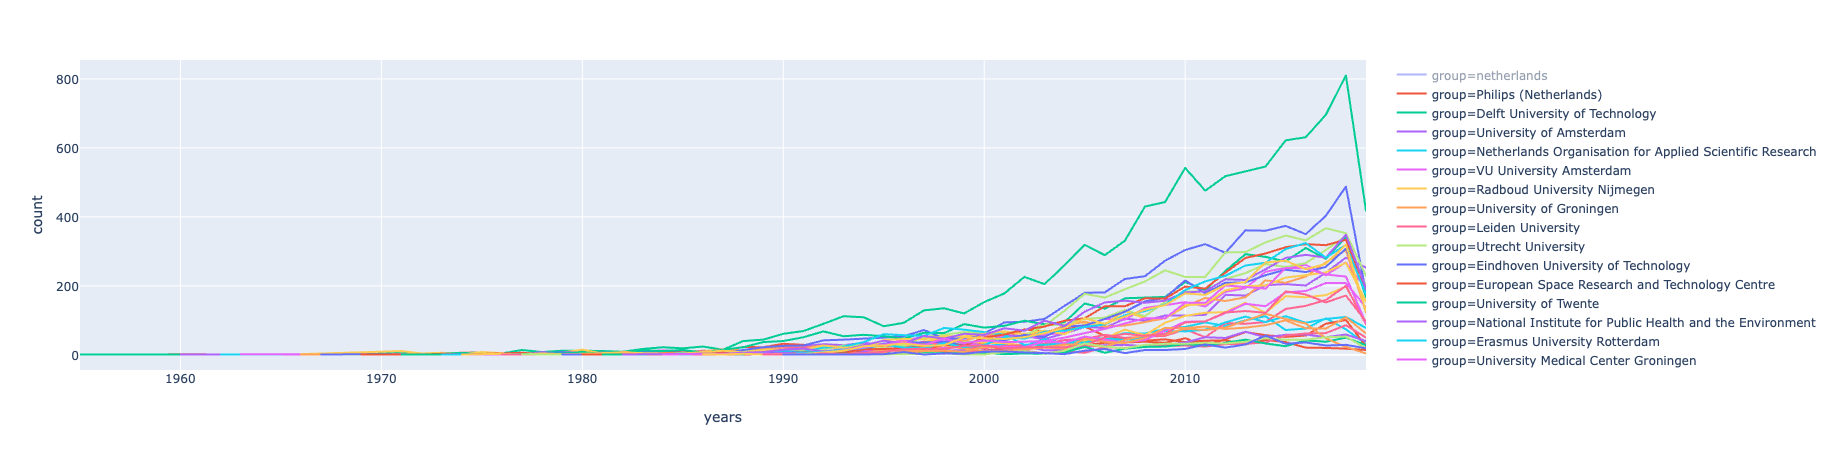

In [229]:
px.line(seed, x="years", y="count", color="group")

#### Have fun and explore the chart!
---